In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import json
from pathlib import Path
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import TripletEvaluator
from sentence_transformers.cross_encoder import CrossEncoder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import spacy
import time

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

 # 0: Dataset Paths

In [3]:
Path('data/raw').mkdir(parents=True, exist_ok=True)
Path('data/processed').mkdir(parents=True, exist_ok=True)
Path('models').mkdir(parents=True, exist_ok=True)
Path('results').mkdir(parents=True, exist_ok=True)

homedir = Path.cwd()

# 1: Importing Data

In [21]:
train_df = pd.read_csv(homedir / "dataset" / 'labeled_final_train.csv')
val_df = pd.read_csv(homedir / "dataset" / 'labeled_final_validation.csv')
test_df = pd.read_csv(homedir / "dataset" / 'labeled_final_test.csv')

# Sample datasets to 300 samples each (stratified by label)
SAMPLE_SIZE = 300
train_df = train_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), SAMPLE_SIZE // 2), random_state=42)
).reset_index(drop=True)

val_df = val_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), SAMPLE_SIZE // 2), random_state=42)
).reset_index(drop=True)

test_df = test_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), SAMPLE_SIZE // 2), random_state=42)
).reset_index(drop=True)

# Count paraphrases and non-paraphrases in each split
print("Training set:")
print(f"  Paraphrases: {len(train_df[train_df['label'] == 1])}")
print(f"  Non-paraphrases: {len(train_df[train_df['label'] == 0])}")

print("\nValidation set:")
print(f"  Paraphrases: {len(val_df[val_df['label'] == 1])}")
print(f"  Non-paraphrases: {len(val_df[val_df['label'] == 0])}")

print("\nTest set:")
print(f"  Paraphrases: {len(test_df[test_df['label'] == 1])}")
print(f"  Non-paraphrases: {len(test_df[test_df['label'] == 0])}")

# Extract pairs from each split
train_paraphrase_pairs = train_df[train_df['label'] == 1][['sentence1', 'sentence2']].values.tolist()
train_non_paraphrase_pairs = train_df[train_df['label'] == 0][['sentence1', 'sentence2']].values.tolist()

val_paraphrase_pairs = val_df[val_df['label'] == 1][['sentence1', 'sentence2']].values.tolist()
val_non_paraphrase_pairs = val_df[val_df['label'] == 0][['sentence1', 'sentence2']].values.tolist()

test_paraphrase_pairs = test_df[test_df['label'] == 1][['sentence1', 'sentence2']].values.tolist()
test_non_paraphrase_pairs = test_df[test_df['label'] == 0][['sentence1', 'sentence2']].values.tolist()


Training set:
  Paraphrases: 150
  Non-paraphrases: 150

Validation set:
  Paraphrases: 150
  Non-paraphrases: 150

Test set:
  Paraphrases: 150
  Non-paraphrases: 150


C:\Users\tranh\AppData\Local\Temp\ipykernel_7932\2626474165.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('label', group_keys=False).apply(
C:\Users\tranh\AppData\Local\Temp\ipykernel_7932\2626474165.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df = val_df.groupby('label', group_keys=False).apply(
C:\Users\tranh\AppData\Local\Temp\ipykernel_7932\2626474165.py:15: FutureWa

# 2: Visualizing distributions, test out some data

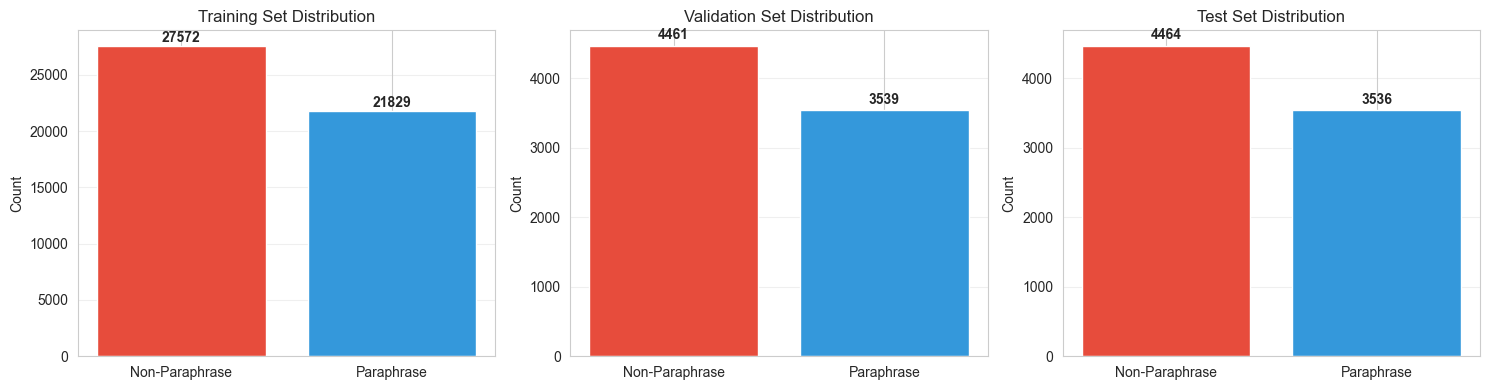


=== Dataset Statistics ===
Total samples: 65401
Total paraphrases: 28904 (44.2%)
Total non-paraphrases: 36497 (55.8%)

=== Sentence Length Statistics (Training Set) ===
Sentence 1 - Mean: 21.3, Median: 21
Sentence 2 - Mean: 21.3, Median: 21

=== Sentence Length Statistics (Training Set) ===
Sentence 1 - Mean: 21.3, Median: 21
Sentence 2 - Mean: 21.3, Median: 21


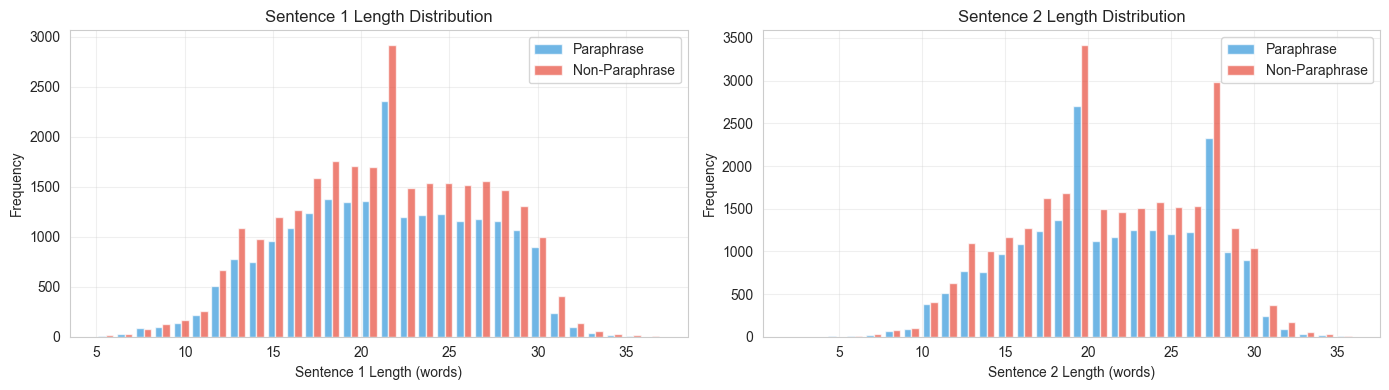


=== RANDOM PARAPHRASE EXAMPLES ===

[Example 1]
Sentence 1: William died in 1859 and Elizabeth died the following year .
Sentence 2: In 1859 , William and Elizabeth died the following year .

[Example 2]
Sentence 1: The leaves are generally 1.5-4 mm wide and 0.2-0.7 mm long .
Sentence 2: The leaves are typically 1.5-4 mm wide and 0.2-0.7 mm long .

[Example 3]
Sentence 1: Drummer Wayne Bennett left the band in June 2007 and was replaced by Ben Timony .
Sentence 2: In June 2007 , drummer Wayne Bennett left the band and was replaced by Ben Timony .

[Example 4]
Sentence 1: Their skin also secretes chemicals that are poisonous and sometimes harmful to predators .
Sentence 2: Also , their skin secretes chemicals that are poisonous , and sometimes distasteful , to predators .

[Example 5]
Sentence 1: When the Florentine Republic fell in 1530 , Volterra came under the control of the Medici family and later followed the history of the Grand Duchy of Tuscany .
Sentence 2: When the Florentine 

In [12]:
# Visualize label distribution across splits
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (df, name) in enumerate([(train_df, 'Training'), (val_df, 'Validation'), (test_df, 'Test')]):
    label_counts = df['label'].value_counts()
    axes[idx].bar(['Non-Paraphrase', 'Paraphrase'], 
                  [label_counts.get(0, 0), label_counts.get(1, 0)],
                  color=['#e74c3c', '#3498db'])
    axes[idx].set_title(f'{name} Set Distribution')
    axes[idx].set_ylabel('Count')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, v in enumerate([label_counts.get(0, 0), label_counts.get(1, 0)]):
        axes[idx].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Overall statistics
print("\n=== Dataset Statistics ===")
total_samples = len(train_df) + len(val_df) + len(test_df)
total_paraphrases = len(train_df[train_df['label'] == 1]) + len(val_df[val_df['label'] == 1]) + len(test_df[test_df['label'] == 1])
total_non_paraphrases = len(train_df[train_df['label'] == 0]) + len(val_df[val_df['label'] == 0]) + len(test_df[test_df['label'] == 0])

print(f"Total samples: {total_samples}")
print(f"Total paraphrases: {total_paraphrases} ({total_paraphrases/total_samples*100:.1f}%)")
print(f"Total non-paraphrases: {total_non_paraphrases} ({total_non_paraphrases/total_samples*100:.1f}%)")

# Sentence length statistics
train_df['len1'] = train_df['sentence1'].str.split().str.len()
train_df['len2'] = train_df['sentence2'].str.split().str.len()

print("\n=== Sentence Length Statistics (Training Set) ===")
print(f"Sentence 1 - Mean: {train_df['len1'].mean():.1f}, Median: {train_df['len1'].median():.0f}")
print(f"Sentence 2 - Mean: {train_df['len2'].mean():.1f}, Median: {train_df['len2'].median():.0f}")

# Plot sentence length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist([train_df[train_df['label'] == 1]['len1'], train_df[train_df['label'] == 0]['len1']], 
             bins=30, label=['Paraphrase', 'Non-Paraphrase'], alpha=0.7, color=['#3498db', '#e74c3c'])
axes[0].set_xlabel('Sentence 1 Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Sentence 1 Length Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist([train_df[train_df['label'] == 1]['len2'], train_df[train_df['label'] == 0]['len2']], 
             bins=30, label=['Paraphrase', 'Non-Paraphrase'], alpha=0.7, color=['#3498db', '#e74c3c'])
axes[1].set_xlabel('Sentence 2 Length (words)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Sentence 2 Length Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display random examples
print("\n" + "="*80)
print("=== RANDOM PARAPHRASE EXAMPLES ===")
print("="*80)
paraphrase_samples = train_df[train_df['label'] == 1].sample(5, random_state=42)
for i, (idx, row) in enumerate(paraphrase_samples.iterrows(), 1):
    print(f"\n[Example {i}]")
    print(f"Sentence 1: {row['sentence1']}")
    print(f"Sentence 2: {row['sentence2']}")

print("\n" + "="*80)
print("=== RANDOM NON-PARAPHRASE EXAMPLES ===")
print("="*80)
non_paraphrase_samples = train_df[train_df['label'] == 0].sample(5, random_state=42)
for i, (idx, row) in enumerate(non_paraphrase_samples.iterrows(), 1):
    print(f"\n[Example {i}]")
    print(f"Sentence 1: {row['sentence1']}")
    print(f"Sentence 2: {row['sentence2']}")


# 3: Base Case: TF-IDF classifier


[1/4] Vectorizing text with TF-IDF...
   Vectorization completed in 1.91s
   Feature dimensions: 5000

[2/4] Training Logistic Regression classifier...
   Training completed in 0.04s

[3/4] Making predictions...

[4/4] Evaluation Results:

--------------------------------------------------------------------------------
TRAINING SET PERFORMANCE
--------------------------------------------------------------------------------
                precision    recall  f1-score   support

Non-Paraphrase     0.6268    0.6865    0.6553     27572
    Paraphrase     0.5499    0.4837    0.5146     21829

      accuracy                         0.5969     49401
     macro avg     0.5883    0.5851    0.5850     49401
  weighted avg     0.5928    0.5969    0.5931     49401

ROC-AUC Score: 0.6211

--------------------------------------------------------------------------------
VALIDATION SET PERFORMANCE
--------------------------------------------------------------------------------
                preci

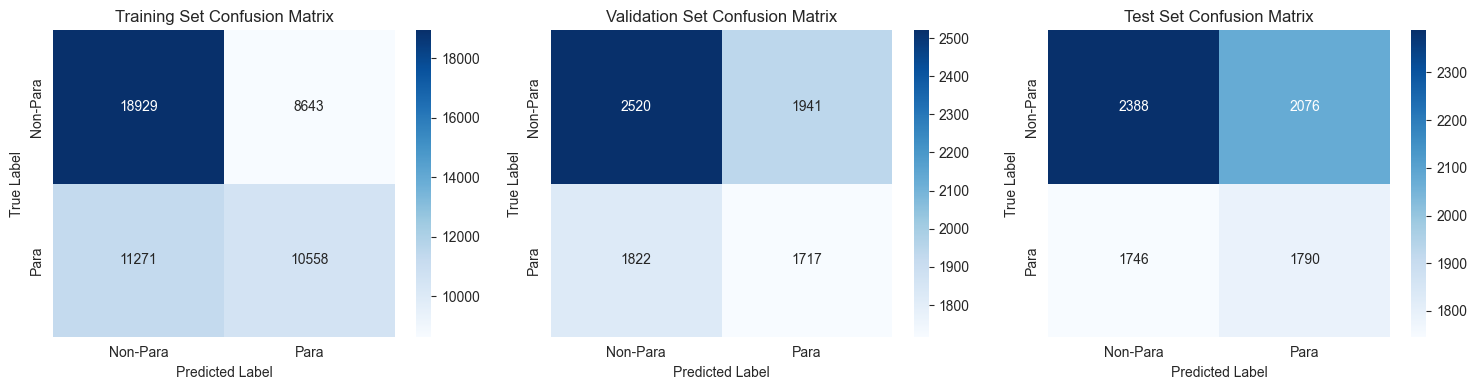

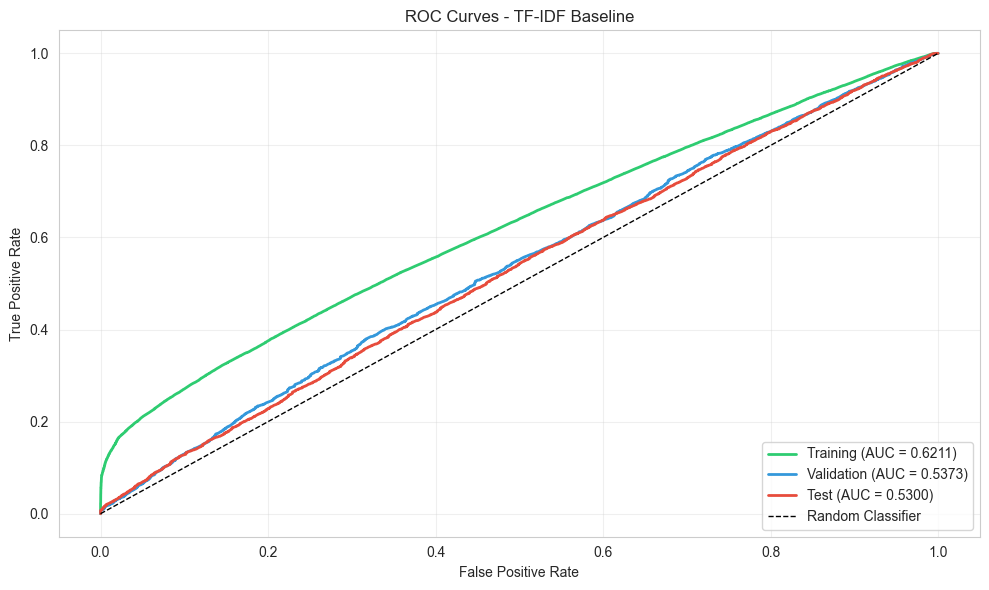


SUMMARY
model: TF-IDF + Logistic Regression
train_accuracy: 0.5969
val_accuracy: 0.5296
test_accuracy: 0.5222
train_auc: 0.6211
val_auc: 0.5373
test_auc: 0.5300


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import time

# Combine sentence pairs for TF-IDF
def combine_sentences(df):
    """Combine sentence pairs with separator for TF-IDF"""
    return df['sentence1'] + ' [SEP] ' + df['sentence2']

train_combined = combine_sentences(train_df)
val_combined = combine_sentences(val_df)
test_combined = combine_sentences(test_df)

# Initialize TF-IDF vectorizer
print("\n[1/4] Vectorizing text with TF-IDF...")
start_time = time.time()

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

# Fit on training data and transform all splits
X_train_tfidf = tfidf.fit_transform(train_combined)
X_val_tfidf = tfidf.transform(val_combined)
X_test_tfidf = tfidf.transform(test_combined)

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

print(f"   Vectorization completed in {time.time() - start_time:.2f}s")
print(f"   Feature dimensions: {X_train_tfidf.shape[1]}")

# Train Logistic Regression classifier
print("\n[2/4] Training Logistic Regression classifier...")
start_time = time.time()

lr_model = LogisticRegression(
    max_iter=10000,
    C=0.5,
    class_weight='balanced',
    random_state=42
)

lr_model.fit(X_train_tfidf, y_train)
print(f"   Training completed in {time.time() - start_time:.2f}s")

# Make predictions
print("\n[3/4] Making predictions...")
train_pred = lr_model.predict(X_train_tfidf)
val_pred = lr_model.predict(X_val_tfidf)
test_pred = lr_model.predict(X_test_tfidf)

train_pred_proba = lr_model.predict_proba(X_train_tfidf)[:, 1]
val_pred_proba = lr_model.predict_proba(X_val_tfidf)[:, 1]
test_pred_proba = lr_model.predict_proba(X_test_tfidf)[:, 1]

def tfidf_pred(sen1, sen2) -> float:
    pass

# Evaluate on all splits
print("\n[4/4] Evaluation Results:")
print("\n" + "-"*80)
print("TRAINING SET PERFORMANCE")
print("-"*80)
print(classification_report(y_train, train_pred, target_names=['Non-Paraphrase', 'Paraphrase'], digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_train, train_pred_proba):.4f}")

print("\n" + "-"*80)
print("VALIDATION SET PERFORMANCE")
print("-"*80)
print(classification_report(y_val, val_pred, target_names=['Non-Paraphrase', 'Paraphrase'], digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_val, val_pred_proba):.4f}")

print("\n" + "-"*80)
print("TEST SET PERFORMANCE")
print("-"*80)
print(classification_report(y_test, test_pred, target_names=['Non-Paraphrase', 'Paraphrase'], digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_test, test_pred_proba):.4f}")

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (y_true, y_pred, name) in enumerate([
    (y_train, train_pred, 'Training'),
    (y_val, val_pred, 'Validation'),
    (y_test, test_pred, 'Test')
]):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-Para', 'Para'],
                yticklabels=['Non-Para', 'Para'])
    axes[idx].set_title(f'{name} Set Confusion Matrix')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# ROC curves
fig, ax = plt.subplots(figsize=(10, 6))

for y_true, y_pred_proba, name, color in [
    (y_train, train_pred_proba, 'Training', '#2ecc71'),
    (y_val, val_pred_proba, 'Validation', '#3498db'),
    (y_test, test_pred_proba, 'Test', '#e74c3c')
]:
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2, color=color)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - TF-IDF Baseline')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Save results
tfidf_results = {
    'model': 'TF-IDF + Logistic Regression',
    'train_accuracy': accuracy_score(y_train, train_pred),
    'val_accuracy': accuracy_score(y_val, val_pred),
    'test_accuracy': accuracy_score(y_test, test_pred),
    'train_auc': roc_auc_score(y_train, train_pred_proba),
    'val_auc': roc_auc_score(y_val, val_pred_proba),
    'test_auc': roc_auc_score(y_test, test_pred_proba)
}

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
for key, value in tfidf_results.items():
    if key != 'model':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")


SPACY EMBEDDINGS CLASSIFIER (OPTIMIZED)

[1/5] Loading spaCy model...
   Loaded: en_core_web_md
   Vector dimensions: 300
   Disabled unnecessary pipeline components for speed

[2/5] Extracting spaCy features...
   Processing sentence pairs in batches...
   Loaded: en_core_web_md
   Vector dimensions: 300
   Disabled unnecessary pipeline components for speed

[2/5] Extracting spaCy features...
   Processing sentence pairs in batches...
   Training set: (49401, 602)
   Processing sentence pairs in batches...
   Training set: (49401, 602)
   Processing sentence pairs in batches...
   Validation set: (8000, 602)
   Processing sentence pairs in batches...
   Validation set: (8000, 602)
   Processing sentence pairs in batches...
   Test set: (8000, 602)
   Feature extraction completed in 10.27s
   Zero vector ratio: 0.0000

[3/5] Training Logistic Regression classifier...
   Test set: (8000, 602)
   Feature extraction completed in 10.27s
   Zero vector ratio: 0.0000

[3/5] Training Logistic

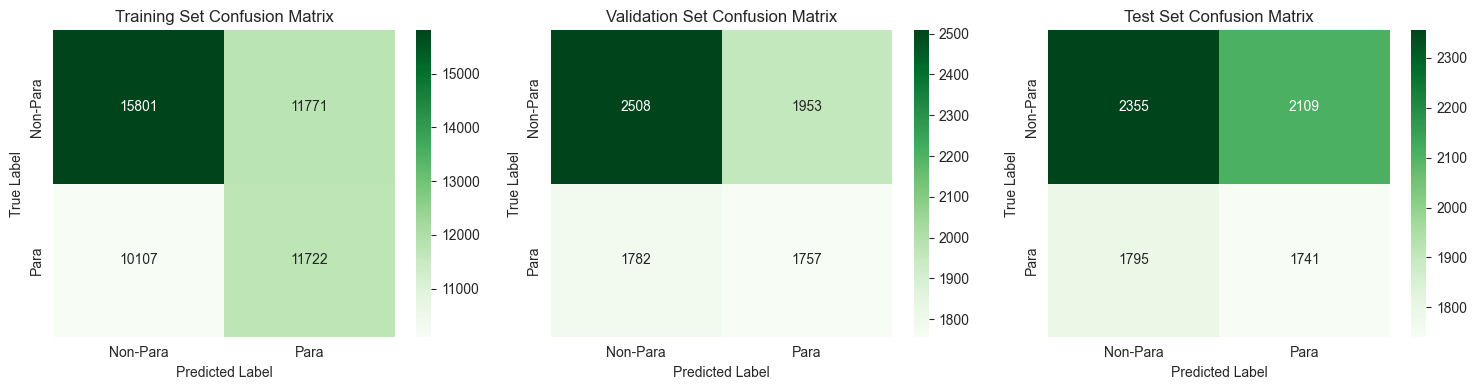

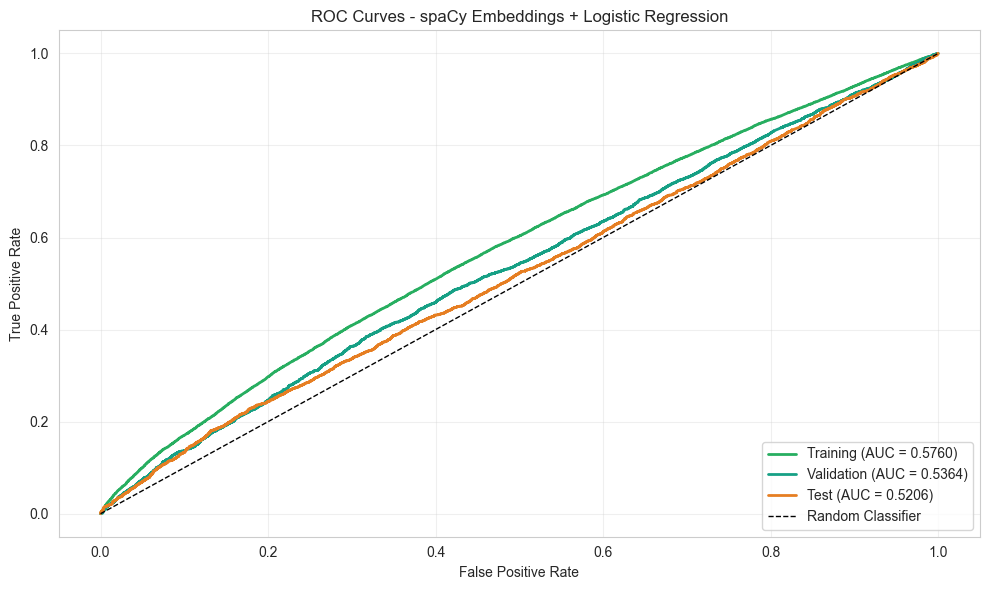


SUMMARY - spaCy Model
model: spaCy Embeddings + Logistic Regression
train_accuracy: 0.5571
val_accuracy: 0.5331
test_accuracy: 0.5120
train_auc: 0.5760
val_auc: 0.5364
test_auc: 0.5206

COMPARISON: TF-IDF vs spaCy
Metric               TF-IDF          spaCy           Difference     
--------------------------------------------------------------------------------
train_accuracy       0.5969          0.5571          -0.0398
val_accuracy         0.5296          0.5331          +0.0035
test_accuracy        0.5222          0.5120          -0.0102
train_auc            0.6211          0.5760          -0.0451
val_auc              0.5373          0.5364          -0.0009
test_auc             0.5300          0.5206          -0.0094


In [13]:
print("="*80)
print("SPACY EMBEDDINGS CLASSIFIER (OPTIMIZED)")
print("="*80)

# Load spaCy model with word vectors
print("\n[1/5] Loading spaCy model...")
try:
    nlp = spacy.load('en_core_web_md')  # Medium model with word vectors (300 dim)
    print("   Loaded: en_core_web_md")
    has_vectors = True
except:
    try:
        nlp = spacy.load('en_core_web_lg')  # Try large model
        print("   Loaded: en_core_web_lg")
        has_vectors = True
    except:
        print("   WARNING: No spaCy model with word vectors found!")
        print("   Install with: python -m spacy download en_core_web_md")
        print("   Skipping spaCy model...")
        has_vectors = False

if has_vectors:
    # Check vector dimensions
    test_doc = nlp("test")
    vector_dim = test_doc.vector.shape[0]
    print(f"   Vector dimensions: {vector_dim}")
    
    if vector_dim == 0:
        print("   ERROR: Model has no word vectors! Skipping...")
        has_vectors = False
    else:
        # Disable unnecessary pipeline components for speed
        nlp.select_pipes(enable=[])  # Disable all pipes except tokenizer
        print("   Disabled unnecessary pipeline components for speed")

        # Extract spaCy embeddings (OPTIMIZED with batch processing)
        def get_spacy_embeddings_batch(sentences, nlp, batch_size=1000):
            """Get document embeddings from spaCy with batch processing"""
            embeddings = []
            
            # Process in batches using nlp.pipe() which is much faster
            for doc in nlp.pipe(sentences, batch_size=batch_size):
                embeddings.append(doc.vector)
            
            return np.array(embeddings)

        def get_pair_features_fast(df, nlp):
            """Extract features from sentence pairs using spaCy (optimized)"""
            print("   Processing sentence pairs in batches...")
            
            # Get embeddings for both sentences using batch processing
            sent1_embeddings = get_spacy_embeddings_batch(df['sentence1'].tolist(), nlp)
            sent2_embeddings = get_spacy_embeddings_batch(df['sentence2'].tolist(), nlp)
            
            # Compute similarity features (vectorized operations)
            cosine_sim = np.sum(sent1_embeddings * sent2_embeddings, axis=1) / (
                np.linalg.norm(sent1_embeddings, axis=1) * np.linalg.norm(sent2_embeddings, axis=1) + 1e-8
            )
            
            euclidean_dist = np.linalg.norm(sent1_embeddings - sent2_embeddings, axis=1)
            
            # Concatenate all features: [sent1_emb, sent2_emb, cosine_sim, euclidean_dist]
            features = np.hstack([
                sent1_embeddings,
                sent2_embeddings,
                cosine_sim.reshape(-1, 1),
                euclidean_dist.reshape(-1, 1)
            ])
            
            return features, sent1_embeddings, sent2_embeddings

        # Extract features
        print("\n[2/5] Extracting spaCy features...")
        start_time = time.time()

        X_train_spacy, train_s1_emb, train_s2_emb = get_pair_features_fast(train_df, nlp)
        print(f"   Training set: {X_train_spacy.shape}")

        X_val_spacy, val_s1_emb, val_s2_emb = get_pair_features_fast(val_df, nlp)
        print(f"   Validation set: {X_val_spacy.shape}")

        X_test_spacy, test_s1_emb, test_s2_emb = get_pair_features_fast(test_df, nlp)
        print(f"   Test set: {X_test_spacy.shape}")

        print(f"   Feature extraction completed in {time.time() - start_time:.2f}s")

        # Check for zero vectors (indicates problem)
        zero_ratio = np.sum(np.all(X_train_spacy == 0, axis=1)) / len(X_train_spacy)
        print(f"   Zero vector ratio: {zero_ratio:.4f}")
        
        if zero_ratio > 0.1:
            print("   WARNING: High ratio of zero vectors - model may not work properly!")

        # Train Logistic Regression classifier (better for this case)
        print("\n[3/5] Training Logistic Regression classifier...")
        start_time = time.time()

        lr_spacy_model = LogisticRegression(
            max_iter=1000,
            C=1.0,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )

        lr_spacy_model.fit(X_train_spacy, y_train)
        print(f"   Training completed in {time.time() - start_time:.2f}s")

        # Make predictions
        print("\n[4/5] Making predictions...")
        train_pred_spacy = lr_spacy_model.predict(X_train_spacy)
        val_pred_spacy = lr_spacy_model.predict(X_val_spacy)
        test_pred_spacy = lr_spacy_model.predict(X_test_spacy)

        train_pred_proba_spacy = lr_spacy_model.predict_proba(X_train_spacy)[:, 1]
        val_pred_proba_spacy = lr_spacy_model.predict_proba(X_val_spacy)[:, 1]
        test_pred_proba_spacy = lr_spacy_model.predict_proba(X_test_spacy)[:, 1]

        # Evaluate on all splits
        print("\n[5/5] Evaluation Results:")
        print("\n" + "-"*80)
        print("TRAINING SET PERFORMANCE")
        print("-"*80)
        print(classification_report(y_train, train_pred_spacy, target_names=['Non-Paraphrase', 'Paraphrase'], digits=4))
        print(f"ROC-AUC Score: {roc_auc_score(y_train, train_pred_proba_spacy):.4f}")

        print("\n" + "-"*80)
        print("VALIDATION SET PERFORMANCE")
        print("-"*80)
        print(classification_report(y_val, val_pred_spacy, target_names=['Non-Paraphrase', 'Paraphrase'], digits=4))
        print(f"ROC-AUC Score: {roc_auc_score(y_val, val_pred_proba_spacy):.4f}")

        print("\n" + "-"*80)
        print("TEST SET PERFORMANCE")
        print("-"*80)
        print(classification_report(y_test, test_pred_spacy, target_names=['Non-Paraphrase', 'Paraphrase'], digits=4))
        print(f"ROC-AUC Score: {roc_auc_score(y_test, test_pred_proba_spacy):.4f}")

        # Confusion matrices
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        for idx, (y_true, y_pred, name) in enumerate([
            (y_train, train_pred_spacy, 'Training'),
            (y_val, val_pred_spacy, 'Validation'),
            (y_test, test_pred_spacy, 'Test')
        ]):
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[idx],
                        xticklabels=['Non-Para', 'Para'],
                        yticklabels=['Non-Para', 'Para'])
            axes[idx].set_title(f'{name} Set Confusion Matrix')
            axes[idx].set_ylabel('True Label')
            axes[idx].set_xlabel('Predicted Label')

        plt.tight_layout()
        plt.show()

        # ROC curves
        fig, ax = plt.subplots(figsize=(10, 6))

        for y_true, y_pred_proba, name, color in [
            (y_train, train_pred_proba_spacy, 'Training', '#27ae60'),
            (y_val, val_pred_proba_spacy, 'Validation', '#16a085'),
            (y_test, test_pred_proba_spacy, 'Test', '#e67e22')
        ]:
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            auc = roc_auc_score(y_true, y_pred_proba)
            ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2, color=color)

        ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curves - spaCy Embeddings + Logistic Regression')
        ax.legend(loc='lower right')
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Save results
        spacy_results = {
            'model': 'spaCy Embeddings + Logistic Regression',
            'train_accuracy': accuracy_score(y_train, train_pred_spacy),
            'val_accuracy': accuracy_score(y_val, val_pred_spacy),
            'test_accuracy': accuracy_score(y_test, test_pred_spacy),
            'train_auc': roc_auc_score(y_train, train_pred_proba_spacy),
            'val_auc': roc_auc_score(y_val, val_pred_proba_spacy),
            'test_auc': roc_auc_score(y_test, test_pred_proba_spacy)
        }

        print("\n" + "="*80)
        print("SUMMARY - spaCy Model")
        print("="*80)
        for key, value in spacy_results.items():
            if key != 'model':
                print(f"{key}: {value:.4f}")
            else:
                print(f"{key}: {value}")

        # Compare with TF-IDF
        print("\n" + "="*80)
        print("COMPARISON: TF-IDF vs spaCy")
        print("="*80)
        print(f"{'Metric':<20} {'TF-IDF':<15} {'spaCy':<15} {'Difference':<15}")
        print("-"*80)
        for metric in ['train_accuracy', 'val_accuracy', 'test_accuracy', 'train_auc', 'val_auc', 'test_auc']:
            tfidf_val = tfidf_results[metric]
            spacy_val = spacy_results[metric]
            diff = spacy_val - tfidf_val
            print(f"{metric:<20} {tfidf_val:<15.4f} {spacy_val:<15.4f} {diff:+.4f}")
else:
    print("\n" + "="*80)
    print("SKIPPING SPACY MODEL - NO WORD VECTORS AVAILABLE")
    print("="*80)
    print("\nTo use spaCy embeddings, install a model with vectors:")
    print("  python -m spacy download en_core_web_md")
    print("or:")
    print("  python -m spacy download en_core_web_lg")
    
    # Create dummy results for comparison
    spacy_results = {
        'model': 'spaCy Embeddings (SKIPPED)',
        'train_accuracy': 0.0,
        'val_accuracy': 0.0,
        'test_accuracy': 0.0,
        'train_auc': 0.5,
        'val_auc': 0.5,
        'test_auc': 0.5
    }


# 4: BERT as feature extractor

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

print("="*80)
print("BERT AS FEATURE EXTRACTOR (OPTIMIZED)")
print("="*80)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Load pre-trained BERT model
print("\n[1/6] Loading BERT model...")
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.to(device)
bert_model.eval()
print(f"   Loaded: {model_name}")

def get_bert_embeddings(sentences, tokenizer, model, device, batch_size=64):
    """Extract [CLS] token embeddings from BERT (optimized batch size)"""
    embeddings = []
    
    with torch.no_grad():
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            
            # Tokenize
            encoded = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors='pt'
            )
            
            # Move to device
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)
            
            # Get BERT output
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Use [CLS] token embedding (first token)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    
    return np.vstack(embeddings)

def get_bert_pair_features(df, tokenizer, model, device):
    """Extract BERT features from sentence pairs"""
    print("   Processing sentence pairs...")
    
    # Get embeddings for both sentences
    sent1_embeddings = get_bert_embeddings(df['sentence1'].tolist(), tokenizer, model, device)
    sent2_embeddings = get_bert_embeddings(df['sentence2'].tolist(), tokenizer, model, device)
    
    # Compute similarity features
    cosine_sim = np.sum(sent1_embeddings * sent2_embeddings, axis=1) / (
        np.linalg.norm(sent1_embeddings, axis=1) * np.linalg.norm(sent2_embeddings, axis=1) + 1e-8
    )
    
    euclidean_dist = np.linalg.norm(sent1_embeddings - sent2_embeddings, axis=1)
    
    # Element-wise difference and product
    diff = np.abs(sent1_embeddings - sent2_embeddings)
    product = sent1_embeddings * sent2_embeddings
    
    # Concatenate all features
    features = np.hstack([
        sent1_embeddings,
        sent2_embeddings,
        diff,
        product,
        cosine_sim.reshape(-1, 1),
        euclidean_dist.reshape(-1, 1)
    ])
    
    return features

# For faster training, use a sample of training data
print("\n[2/6] Sampling training data for faster training...")
SAMPLE_SIZE = 200  # Use 200 samples for BERT training

# Create stratified sample to maintain class balance
train_sample_df = train_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), SAMPLE_SIZE // 2), random_state=42)
)

print(f"   Full training set: {len(train_df)} samples")
print(f"   Sampled training set: {len(train_sample_df)} samples")
print(f"   Sample class distribution:")
print(f"     Non-Paraphrase: {len(train_sample_df[train_sample_df['label'] == 0])}")
print(f"     Paraphrase: {len(train_sample_df[train_sample_df['label'] == 1])}")

# Extract BERT features
print("\n[3/6] Extracting BERT features...")
start_time = time.time()

X_train_bert_sample = get_bert_pair_features(train_sample_df, tokenizer, bert_model, device)
y_train_sample = train_sample_df['label'].values
print(f"   Training sample: {X_train_bert_sample.shape}")

X_val_bert = get_bert_pair_features(val_df, tokenizer, bert_model, device)
print(f"   Validation set: {X_val_bert.shape}")

X_test_bert = get_bert_pair_features(test_df, tokenizer, bert_model, device)
print(f"   Test set: {X_test_bert.shape}")

print(f"   Feature extraction completed in {time.time() - start_time:.2f}s")

# Train Logistic Regression classifier on sample
print("\n[4/6] Training Logistic Regression classifier on sampled data...")
start_time = time.time()

bert_lr_model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

bert_lr_model.fit(X_train_bert_sample, y_train_sample)
print(f"   Training completed in {time.time() - start_time:.2f}s")

# Make predictions
print("\n[5/6] Making predictions...")
train_pred_bert = bert_lr_model.predict(X_train_bert_sample)
val_pred_bert = bert_lr_model.predict(X_val_bert)
test_pred_bert = bert_lr_model.predict(X_test_bert)

train_pred_proba_bert = bert_lr_model.predict_proba(X_train_bert_sample)[:, 1]
val_pred_proba_bert = bert_lr_model.predict_proba(X_val_bert)[:, 1]
test_pred_proba_bert = bert_lr_model.predict_proba(X_test_bert)[:, 1]

# Evaluate on all splits
print("\n[6/6] Evaluation Results:")
print("\n" + "-"*80)
print("TRAINING SAMPLE PERFORMANCE")
print("-"*80)
print(classification_report(y_train_sample, train_pred_bert, target_names=['Non-Paraphrase', 'Paraphrase'], digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_train_sample, train_pred_proba_bert):.4f}")

print("\n" + "-"*80)
print("VALIDATION SET PERFORMANCE")
print("-"*80)
print(classification_report(y_val, val_pred_bert, target_names=['Non-Paraphrase', 'Paraphrase'], digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_val, val_pred_proba_bert):.4f}")

print("\n" + "-"*80)
print("TEST SET PERFORMANCE")
print("-"*80)
print(classification_report(y_test, test_pred_bert, target_names=['Non-Paraphrase', 'Paraphrase'], digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_test, test_pred_proba_bert):.4f}")

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (y_true, y_pred, name) in enumerate([
    (y_train_sample, train_pred_bert, 'Training Sample'),
    (y_val, val_pred_bert, 'Validation'),
    (y_test, test_pred_bert, 'Test')
]):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[idx],
                xticklabels=['Non-Para', 'Para'],
                yticklabels=['Non-Para', 'Para'])
    axes[idx].set_title(f'{name} Set Confusion Matrix')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# ROC curves
fig, ax = plt.subplots(figsize=(10, 6))

for y_true, y_pred_proba, name, color in [
    (y_train_sample, train_pred_proba_bert, 'Training Sample', '#9b59b6'),
    (y_val, val_pred_proba_bert, 'Validation', '#8e44ad'),
    (y_test, test_pred_proba_bert, 'Test', '#e91e63')
]:
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2, color=color)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - BERT Features + Logistic Regression (Sampled Training)')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Save results
bert_results = {
    'model': 'BERT Features + Logistic Regression (Sampled)',
    'train_accuracy': accuracy_score(y_train_sample, train_pred_bert),
    'val_accuracy': accuracy_score(y_val, val_pred_bert),
    'test_accuracy': accuracy_score(y_test, test_pred_bert),
    'train_auc': roc_auc_score(y_train_sample, train_pred_proba_bert),
    'val_auc': roc_auc_score(y_val, val_pred_proba_bert),
    'test_auc': roc_auc_score(y_test, test_pred_proba_bert),
    'training_samples': len(train_sample_df)
}

print("\n" + "="*80)
print("SUMMARY - BERT Model (Sampled Training)")
print("="*80)
for key, value in bert_results.items():
    if key not in ['model', 'training_samples']:
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Compare all three models
print("\n" + "="*80)
print("COMPARISON: TF-IDF vs spaCy vs BERT")
print("="*80)
print(f"{'Metric':<20} {'TF-IDF':<12} {'spaCy':<12} {'BERT':<12}")
print("-"*80)
for metric in ['val_accuracy', 'test_accuracy', 'val_auc', 'test_auc']:
    tfidf_val = tfidf_results[metric]
    spacy_val = spacy_results[metric]
    bert_val = bert_results[metric]
    print(f"{metric:<20} {tfidf_val:<12.4f} {spacy_val:<12.4f} {bert_val:<12.4f}")

print(f"\nNote: BERT trained on {len(train_sample_df)} samples (vs {len(train_df)} full training set)")


BERT AS FEATURE EXTRACTOR (OPTIMIZED)

Using device: cpu

[1/6] Loading BERT model...
   Loaded: bert-base-uncased

[2/6] Sampling training data for faster training...
   Full training set: 49401 samples
   Sampled training set: 2000 samples
   Sample class distribution:
     Non-Paraphrase: 1000
     Paraphrase: 1000

[3/6] Extracting BERT features...
   Processing sentence pairs...
   Loaded: bert-base-uncased

[2/6] Sampling training data for faster training...
   Full training set: 49401 samples
   Sampled training set: 2000 samples
   Sample class distribution:
     Non-Paraphrase: 1000
     Paraphrase: 1000

[3/6] Extracting BERT features...
   Processing sentence pairs...


C:\Users\tranh\AppData\Local\Temp\ipykernel_7932\3296588509.py:87: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_sample_df = train_df.groupby('label', group_keys=False).apply(


   Training sample: (2000, 3074)
   Processing sentence pairs...
   Validation set: (8000, 3074)
   Processing sentence pairs...


KeyboardInterrupt: 

# 5: Sentence Transformers & Cross-encoders

In [ ]:
print("="*80)
print("SENTENCE TRANSFORMERS & CROSS-ENCODERS")
print("="*80)

# Load models
print("\n[1/5] Loading models...")
start_time = time.time()

model_all = SentenceTransformer("all-MiniLM-L6-v2")
print(f"   Loaded: all-MiniLM-L6-v2")

model_para = SentenceTransformer("paraphrase-MiniLM-L6-v2")
print(f"   Loaded: paraphrase-MiniLM-L6-v2")

model_cross = CrossEncoder("cross-encoder/ms-marco-MiniLM-L6-v2")
print(f"   Loaded: cross-encoder/ms-marco-MiniLM-L6-v2")

print(f"   Model loading completed in {time.time() - start_time:.2f}s")

# Helper function to compute cosine similarity from embeddings
def get_similarity_scores(model, df):
    """Compute cosine similarity scores using sentence transformer"""
    print(f"   Encoding sentences...")
    emb1 = model.encode(df['sentence1'].tolist(), show_progress_bar=False, batch_size=64)
    emb2 = model.encode(df['sentence2'].tolist(), show_progress_bar=False, batch_size=64)
    
    # Compute cosine similarity
    similarities = np.sum(emb1 * emb2, axis=1) / (
        np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1) + 1e-8
    )
    return similarities

def get_cross_encoder_scores(model, df):
    """Compute similarity scores using cross-encoder"""
    print(f"   Computing cross-encoder scores...")
    pairs = list(zip(df['sentence1'].tolist(), df['sentence2'].tolist()))
    scores = model.predict(pairs, show_progress_bar=False, batch_size=64)
    return scores

def evaluate_similarity_scores(y_true, scores, threshold=0.5):
    """Evaluate binary classification from similarity scores"""
    y_pred = (scores > threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc = roc_auc_score(y_true, scores)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

# Test on validation set to find best threshold
print("\n[2/5] Finding optimal thresholds on validation set...")

# all-MiniLM
val_scores_all = get_similarity_scores(model_all, val_df)
thresholds = np.arange(0.0, 1.0, 0.05)
best_threshold_all = 0.5
best_f1_all = 0

for thresh in thresholds:
    metrics = evaluate_similarity_scores(y_val, val_scores_all, thresh)
    if metrics['f1'] > best_f1_all:
        best_f1_all = metrics['f1']
        best_threshold_all = thresh

print(f"   all-MiniLM-L6-v2: Best threshold = {best_threshold_all:.2f} (F1 = {best_f1_all:.4f})")

# paraphrase-MiniLM
val_scores_para = get_similarity_scores(model_para, val_df)
best_threshold_para = 0.5
best_f1_para = 0

for thresh in thresholds:
    metrics = evaluate_similarity_scores(y_val, val_scores_para, thresh)
    if metrics['f1'] > best_f1_para:
        best_f1_para = metrics['f1']
        best_threshold_para = thresh

print(f"   paraphrase-MiniLM-L6-v2: Best threshold = {best_threshold_para:.2f} (F1 = {best_f1_para:.4f})")

# Cross-encoder (already outputs probabilities, use 0.5)
val_scores_cross = get_cross_encoder_scores(model_cross, val_df)
best_threshold_cross = 0.5
print(f"   cross-encoder: Using threshold = {best_threshold_cross:.2f}")

# Evaluate on test set
print("\n[3/5] Evaluating on test set...")

test_scores_all = get_similarity_scores(model_all, test_df)
test_metrics_all = evaluate_similarity_scores(y_test, test_scores_all, best_threshold_all)

test_scores_para = get_similarity_scores(model_para, test_df)
test_metrics_para = evaluate_similarity_scores(y_test, test_scores_para, best_threshold_para)

test_scores_cross = get_cross_encoder_scores(model_cross, test_df)
test_metrics_cross = evaluate_similarity_scores(y_test, test_scores_cross, best_threshold_cross)

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)

for model_name, metrics in [
    ('all-MiniLM-L6-v2', test_metrics_all),
    ('paraphrase-MiniLM-L6-v2', test_metrics_para),
    ('cross-encoder', test_metrics_cross)
]:
    print(f"\n{model_name}:")
    print(f"   Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1 Score:  {metrics['f1']:.4f}")
    print(f"   ROC-AUC:   {metrics['auc']:.4f}")

# Visualize ROC curves
print("\n[4/5] Generating visualizations...")

fig, ax = plt.subplots(figsize=(10, 6))

for scores, name, color in [
    (test_scores_all, 'all-MiniLM-L6-v2', '#3498db'),
    (test_scores_para, 'paraphrase-MiniLM-L6-v2', '#2ecc71'),
    (test_scores_cross, 'cross-encoder', '#e74c3c')
]:
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2, color=color)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Sentence Transformers & Cross-Encoder')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Store results
sbert_results = {
    'all_minilm': test_metrics_all,
    'paraphrase_minilm': test_metrics_para,
    'cross_encoder': test_metrics_cross
}

# Compare with previous models
print("\n" + "="*80)
print("MODEL COMPARISON - TEST SET")
print("="*80)
print(f"{'Model':<35} {'Accuracy':<12} {'F1':<12} {'AUC':<12}")
print("-"*80)
print(f"{'TF-IDF + LR':<35} {tfidf_results['test_accuracy']:<12.4f} {0.0:<12.4f} {tfidf_results['test_auc']:<12.4f}")
print(f"{'spaCy + LR':<35} {spacy_results['test_accuracy']:<12.4f} {0.0:<12.4f} {spacy_results['test_auc']:<12.4f}")
print(f"{'BERT Features + LR':<35} {bert_results['test_accuracy']:<12.4f} {0.0:<12.4f} {bert_results['test_auc']:<12.4f}")
print(f"{'all-MiniLM-L6-v2':<35} {test_metrics_all['accuracy']:<12.4f} {test_metrics_all['f1']:<12.4f} {test_metrics_all['auc']:<12.4f}")
print(f"{'paraphrase-MiniLM-L6-v2':<35} {test_metrics_para['accuracy']:<12.4f} {test_metrics_para['f1']:<12.4f} {test_metrics_para['auc']:<12.4f}")
print(f"{'cross-encoder':<35} {test_metrics_cross['accuracy']:<12.4f} {test_metrics_cross['f1']:<12.4f} {test_metrics_cross['auc']:<12.4f}")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


# 6: Testing on difficult cases
- Paragraph-level paraphrasing
- Adjacent topics

In [ ]:
# Difficult test cases for paraphrase detection
# These cases are designed to challenge the models with subtle semantic relationships

# PARAPHRASE PAIRS - High difficulty
# These SHOULD be detected as paraphrases but use very different wording/structure
p_paragraphs = {
    "climate_change": [
        "The rapid increase in global temperatures over the past century has been primarily driven by human activities, particularly the burning of fossil fuels which releases greenhouse gases into the atmosphere. This has led to rising sea levels, extreme weather events, and disruptions to ecosystems worldwide.",
        "Anthropogenic factors, especially the combustion of coal, oil, and natural gas, have been the main contributors to the accelerated warming of Earth's climate system since the industrial revolution. Consequences include oceanic thermal expansion causing coastal flooding, more frequent catastrophic meteorological phenomena, and widespread ecological imbalances."
    ],
    "ai_ethics": [
        "As artificial intelligence systems become more sophisticated and autonomous, society faces crucial questions about accountability when these systems make errors or cause harm. We need clear frameworks for determining who is responsible - the developers, the users, or the AI itself.",
        "The advancement of machine learning technologies toward greater independence raises critical concerns regarding liability attribution in cases of malfunction or damage. Establishing transparent protocols to identify culpable parties among creators, operators, and the algorithmic agents themselves has become imperative."
    ],
    "economic_inequality": [
        "The concentration of wealth in the hands of a small percentage of the population has reached levels not seen since the early 20th century. This disparity undermines social mobility, reduces consumer spending power among the majority, and creates political instability as disenfranchised groups lose faith in existing institutions.",
        "An unprecedented accumulation of financial resources among elite demographics mirrors historical patterns from over a hundred years ago. Such stratification impedes intergenerational economic advancement opportunities, constrains aggregate demand from lower-income cohorts, and fosters civic unrest when marginalized communities perceive systemic exclusion from governance structures."
    ]
}

# NON-PARAPHRASE PAIRS - High difficulty  
# These are on similar topics but express DIFFERENT ideas - should NOT be detected as paraphrases
non_p_paragraphs = {
    "renewable_energy": [
        "Solar and wind power have become increasingly cost-competitive with traditional fossil fuels, making renewable energy a financially viable option for both residential and commercial applications. Government subsidies and technological improvements have accelerated this transition significantly.",
        "Despite the enthusiasm for renewable energy sources, the intermittent nature of solar and wind generation creates substantial challenges for grid stability. Energy storage solutions remain prohibitively expensive for most utilities, and backup fossil fuel plants are still necessary to ensure reliable power supply during periods of low renewable output."
    ],
    "education_technology": [
        "Online learning platforms have democratized access to high-quality educational content, allowing students from remote or underprivileged areas to learn from world-class instructors. This technology has the potential to reduce educational inequality on a global scale.",
        "Research consistently shows that face-to-face instruction produces superior learning outcomes compared to purely digital alternatives, particularly for younger students who require direct supervision and social interaction. The over-reliance on educational technology may actually exacerbate achievement gaps rather than close them."
    ],
    "space_exploration": [
        "Private companies like SpaceX and Blue Origin are revolutionizing space travel by dramatically reducing launch costs through reusable rocket technology. This innovation is opening up possibilities for commercial space tourism and eventual colonization of other planets.",
        "The massive investment in space exploration programs diverts critical resources away from pressing terrestrial problems such as poverty, disease, and environmental degradation. Until we solve fundamental challenges on Earth, ventures beyond our planet represent an irresponsible allocation of human and financial capital."
    ]
}

# ADJACENT TOPIC PAIRS - High difficulty
# These discuss related but distinct concepts - should NOT be detected as paraphrases
adjacent_paragraphs = {
    "memory_vs_learning": [
        "Human memory operates through complex neural networks that encode, store, and retrieve information. The hippocampus plays a crucial role in forming new episodic memories, while the prefrontal cortex is involved in working memory and executive functions.",
        "The process of learning involves creating new neural pathways and strengthening existing connections through repeated exposure and practice. Neuroplasticity enables the brain to adapt and reorganize itself, particularly in response to new experiences and environmental demands."
    ],
    "weather_vs_climate": [
        "Today's weather forecast predicts heavy rainfall and thunderstorms across the northeastern region, with temperatures dropping to unseasonably low levels. Residents are advised to prepare for potential flooding in low-lying areas and to avoid unnecessary travel.",
        "Climate patterns in this region have shifted noticeably over the past three decades, with average annual temperatures rising by 1.5 degrees Celsius. Long-term precipitation trends show decreased snowfall in winter months but increased intensity of summer rainfall events."
    ],
    "stocks_vs_bonds": [
        "Equity investments offer ownership stakes in companies and provide returns through capital appreciation and dividends. Stock prices fluctuate based on company performance, market sentiment, and economic conditions, making them higher-risk but potentially higher-reward investments.",
        "Fixed-income securities represent loans to corporations or governments that pay regular interest payments and return principal at maturity. Bond values are primarily influenced by interest rate changes and credit ratings, offering more stable but typically lower returns than equities."
    ]
}

In [19]:
print("\n" + "="*80)
print("[5/5] TESTING ON DIFFICULT CASES")
print("="*80)

# Create test dataframe from difficult cases
difficult_cases = []

# Add paraphrase pairs (label=1)
for topic, (sent1, sent2) in p_paragraphs.items():
    difficult_cases.append({
        'sentence1': sent1,
        'sentence2': sent2,
        'label': 1,
        'category': 'paraphrase',
        'topic': topic
    })

# Add non-paraphrase pairs (label=0)
for topic, (sent1, sent2) in non_p_paragraphs.items():
    difficult_cases.append({
        'sentence1': sent1,
        'sentence2': sent2,
        'label': 0,
        'category': 'non-paraphrase',
        'topic': topic
    })

# Add adjacent topic pairs (label=0)
for topic, (sent1, sent2) in adjacent_paragraphs.items():
    difficult_cases.append({
        'sentence1': sent1,
        'sentence2': sent2,
        'label': 0,
        'category': 'adjacent',
        'topic': topic
    })

difficult_df = pd.DataFrame(difficult_cases)
y_difficult = difficult_df['label'].values

print(f"\nDifficult cases dataset: {len(difficult_df)} samples")
print(f"  Paraphrases: {len(difficult_df[difficult_df['label'] == 1])}")
print(f"  Non-paraphrases: {len(difficult_df[difficult_df['label'] == 0])}")
print(f"    - Different viewpoints: {len(difficult_df[difficult_df['category'] == 'non-paraphrase'])}")
print(f"    - Adjacent topics: {len(difficult_df[difficult_df['category'] == 'adjacent'])}")

# Test all models on difficult cases
print("\n" + "-"*80)
print("Testing models on difficult cases...")
print("-"*80)

# all-MiniLM
diff_scores_all = get_similarity_scores(model_all, difficult_df)
diff_pred_all = (diff_scores_all > best_threshold_all).astype(int)

# paraphrase-MiniLM
diff_scores_para = get_similarity_scores(model_para, difficult_df)
diff_pred_para = (diff_scores_para > best_threshold_para).astype(int)

# Cross-encoder
diff_scores_cross = get_cross_encoder_scores(model_cross, difficult_df)
diff_pred_cross = (diff_scores_cross > best_threshold_cross).astype(int)

# Display results for each case
print("\n" + "="*80)
print("DETAILED RESULTS - DIFFICULT CASES")
print("="*80)

for idx, row in difficult_df.iterrows():
    print(f"\n[{row['category'].upper()} - {row['topic']}]")
    print(f"Ground Truth: {'PARAPHRASE' if row['label'] == 1 else 'NOT PARAPHRASE'}")
    print(f"\nText 1: {row['sentence1'][:100]}...")
    print(f"Text 2: {row['sentence2'][:100]}...")
    
    print(f"\nModel Predictions:")
    print(f"  all-MiniLM:        {'PARAPHRASE' if diff_pred_all[idx] == 1 else 'NOT PARAPHRASE':<15} (score: {diff_scores_all[idx]:.4f})")
    print(f"  paraphrase-MiniLM: {'PARAPHRASE' if diff_pred_para[idx] == 1 else 'NOT PARAPHRASE':<15} (score: {diff_scores_para[idx]:.4f})")
    print(f"  cross-encoder:     {'PARAPHRASE' if diff_pred_cross[idx] == 1 else 'NOT PARAPHRASE':<15} (score: {diff_scores_cross[idx]:.4f})")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY - DIFFICULT CASES ACCURACY")
print("="*80)

all_acc = accuracy_score(y_difficult, diff_pred_all)
para_acc = accuracy_score(y_difficult, diff_pred_para)
cross_acc = accuracy_score(y_difficult, diff_pred_cross)

print(f"{'Model':<30} {'Overall':<12} {'Paraphrases':<15} {'Non-Paraphrases':<15}")
print("-"*80)

for model_name, preds in [
    ('all-MiniLM-L6-v2', diff_pred_all),
    ('paraphrase-MiniLM-L6-v2', diff_pred_para),
    ('cross-encoder', diff_pred_cross)
]:
    overall_acc = accuracy_score(y_difficult, preds)
    para_mask = difficult_df['label'] == 1
    non_para_mask = difficult_df['label'] == 0
    
    para_acc = accuracy_score(y_difficult[para_mask], preds[para_mask])
    non_para_acc = accuracy_score(y_difficult[non_para_mask], preds[non_para_mask])
    
    print(f"{model_name:<30} {overall_acc:<12.4f} {para_acc:<15.4f} {non_para_acc:<15.4f}")

# Break down by category
print("\n" + "="*80)
print("BREAKDOWN BY CATEGORY")
print("="*80)

for category in ['paraphrase', 'non-paraphrase', 'adjacent']:
    mask = difficult_df['category'] == category
    if mask.sum() == 0:
        continue
    
    print(f"\n{category.upper()} ({mask.sum()} cases):")
    print(f"  all-MiniLM:        {accuracy_score(y_difficult[mask], diff_pred_all[mask]):.4f}")
    print(f"  paraphrase-MiniLM: {accuracy_score(y_difficult[mask], diff_pred_para[mask]):.4f}")
    print(f"  cross-encoder:     {accuracy_score(y_difficult[mask], diff_pred_cross[mask]):.4f}")

# Visualize score distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (scores, name) in enumerate([
    (diff_scores_all, 'all-MiniLM-L6-v2'),
    (diff_scores_para, 'paraphrase-MiniLM-L6-v2'),
    (diff_scores_cross, 'cross-encoder')
]):
    para_scores = scores[difficult_df['label'] == 1]
    non_para_scores = scores[difficult_df['label'] == 0]
    
    axes[idx].hist([para_scores, non_para_scores], bins=10, 
                   label=['Paraphrases', 'Non-Paraphrases'], 
                   alpha=0.7, color=['#3498db', '#e74c3c'])
    axes[idx].set_xlabel('Similarity Score')
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'{name}\nDifficult Cases')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)



[5/5] TESTING ON DIFFICULT CASES

Difficult cases dataset: 9 samples
  Paraphrases: 3
  Non-paraphrases: 6
    - Different viewpoints: 3
    - Adjacent topics: 3

--------------------------------------------------------------------------------
Testing models on difficult cases...
--------------------------------------------------------------------------------


NameError: name 'get_similarity_scores' is not defined

# Final best model: Sentence Transformer/Cross-encoder + Subject Matter Finetuning
## Pros: High accuracy, captures context at a high level
## Cons: Context window might be an issue, high processing demands

# Second best model: Spacy with a classification model

In [ ]:
print("="*80)
print("FINE-TUNING CROSS-ENCODER")
print("="*80)

from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from torch.utils.data import DataLoader
import math

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Prepare data for cross-encoder training
print("\n[1/6] Preparing training data...")

# Use all available training data (already sampled to 300)
print(f"   Using full training set for fine-tuning...")

train_sample_df = train_df

print(f"   Training samples: {len(train_sample_df)}")
print(f"   Class distribution:")
print(f"     Paraphrase: {len(train_sample_df[train_sample_df['label'] == 1])}")
print(f"     Non-Paraphrase: {len(train_sample_df[train_sample_df['label'] == 0])}")

# Create training samples - list of InputExample
train_samples = []
for _, row in train_sample_df.iterrows():
    train_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=float(row['label'])))

print(f"   Created {len(train_samples)} training samples")

# Initialize base model for fine-tuning
print("\n[2/6] Loading base cross-encoder model...")
model_name = 'cross-encoder/ms-marco-MiniLM-L6-v2'
finetuned_model = CrossEncoder(model_name, num_labels=1, max_length=256, device=device)
print(f"   Loaded: {model_name}")

# Create evaluator for validation set
print("\n[3/6] Creating validation evaluator...")
val_samples = []
for _, row in val_df.iterrows():
    val_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=float(row['label'])))

evaluator = CEBinaryClassificationEvaluator.from_input_examples(
    val_samples, 
    name='paraphrase-val'
)
print(f"   Created evaluator with {len(val_samples)} validation samples")

# Configure training
print("\n[4/6] Configuring training parameters...")
num_epochs = 3
batch_size = 16
warmup_steps = math.ceil(len(train_samples) * num_epochs / batch_size * 0.1)

print(f"   Epochs: {num_epochs}")
print(f"   Batch size: {batch_size}")
print(f"   Warmup steps: {warmup_steps}")
print(f"   Total training steps: {math.ceil(len(train_samples) / batch_size) * num_epochs}")

# Fine-tune the model
print("\n[5/6] Fine-tuning cross-encoder...")
print("   This may take several minutes depending on your hardware...")
start_time = time.time()

finetuned_model.fit(
    train_dataloader=DataLoader(train_samples, shuffle=True, batch_size=batch_size),
    evaluator=evaluator,
    epochs=num_epochs,
    evaluation_steps=500,  # Evaluate every 500 steps
    warmup_steps=warmup_steps,
    output_path='./models/finetuned_cross_encoder',
    save_best_model=True,
    show_progress_bar=True
)

print(f"   Fine-tuning completed in {time.time() - start_time:.2f}s")
print(f"   Model saved to: ./models/finetuned_cross_encoder")

# Load the best model for evaluation
print("\n[6/6] Evaluating fine-tuned model...")
best_model = CrossEncoder('./models/finetuned_cross_encoder', device=device)

# Evaluate on test set
def evaluate_cross_encoder(model, df, y_true):
    """Evaluate cross-encoder model"""
    pairs = list(zip(df['sentence1'].tolist(), df['sentence2'].tolist()))
    scores = model.predict(pairs, show_progress_bar=True, batch_size=64)
    
    # Find optimal threshold on validation set if not provided
    preds = (scores > 0.5).astype(int)
    
    accuracy = accuracy_score(y_true, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, preds, average='binary')
    auc = roc_auc_score(y_true, scores)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'scores': scores,
        'predictions': preds
    }

print("   Evaluating on validation set...")
val_results_ft = evaluate_cross_encoder(best_model, val_df, y_val)

print("   Evaluating on test set...")
test_results_ft = evaluate_cross_encoder(best_model, test_df, y_test)

print("\n" + "="*80)
print("FINE-TUNED CROSS-ENCODER RESULTS")
print("="*80)

print("\nVALIDATION SET:")
print(f"   Accuracy:  {val_results_ft['accuracy']:.4f}")
print(f"   Precision: {val_results_ft['precision']:.4f}")
print(f"   Recall:    {val_results_ft['recall']:.4f}")
print(f"   F1 Score:  {val_results_ft['f1']:.4f}")
print(f"   ROC-AUC:   {val_results_ft['auc']:.4f}")

print("\nTEST SET:")
print(f"   Accuracy:  {test_results_ft['accuracy']:.4f}")
print(f"   Precision: {test_results_ft['precision']:.4f}")
print(f"   Recall:    {test_results_ft['recall']:.4f}")
print(f"   F1 Score:  {test_results_ft['f1']:.4f}")
print(f"   ROC-AUC:   {test_results_ft['auc']:.4f}")

# Compare with pre-trained cross-encoder
print("\n" + "="*80)
print("COMPARISON: Pre-trained vs Fine-tuned Cross-Encoder")
print("="*80)
print(f"{'Metric':<15} {'Pre-trained':<15} {'Fine-tuned':<15} {'Improvement':<15}")
print("-"*80)

for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    pretrained_val = test_metrics_cross[metric]
    finetuned_val = test_results_ft[metric]
    improvement = finetuned_val - pretrained_val
    print(f"{metric:<15} {pretrained_val:<15.4f} {finetuned_val:<15.4f} {improvement:+.4f}")

# Visualize ROC curves comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Pre-trained model
fpr_pre, tpr_pre, _ = roc_curve(y_test, test_scores_cross)
auc_pre = roc_auc_score(y_test, test_scores_cross)
ax.plot(fpr_pre, tpr_pre, label=f'Pre-trained (AUC = {auc_pre:.4f})', linewidth=2, color='#e74c3c')

# Fine-tuned model
fpr_ft, tpr_ft, _ = roc_curve(y_test, test_results_ft['scores'])
auc_ft = roc_auc_score(y_test, test_results_ft['scores'])
ax.plot(fpr_ft, tpr_ft, label=f'Fine-tuned (AUC = {auc_ft:.4f})', linewidth=2, color='#2ecc71')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Cross-Encoder Comparison')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Test on difficult cases
print("\n" + "="*80)
print("TESTING FINE-TUNED MODEL ON DIFFICULT CASES")
print("="*80)

diff_results_ft = evaluate_cross_encoder(best_model, difficult_df, y_difficult)

print(f"\nOverall Accuracy: {diff_results_ft['accuracy']:.4f}")

# Detailed breakdown
para_mask = difficult_df['label'] == 1
non_para_mask = difficult_df['label'] == 0

para_acc_ft = accuracy_score(y_difficult[para_mask], diff_results_ft['predictions'][para_mask])
non_para_acc_ft = accuracy_score(y_difficult[non_para_mask], diff_results_ft['predictions'][non_para_mask])

print(f"Paraphrase Accuracy: {para_acc_ft:.4f}")
print(f"Non-Paraphrase Accuracy: {non_para_acc_ft:.4f}")

# Compare with pre-trained on difficult cases
print("\n" + "-"*80)
print("Difficult Cases Comparison:")
print("-"*80)
print(f"{'Category':<25} {'Pre-trained':<15} {'Fine-tuned':<15} {'Improvement':<15}")
print("-"*80)

para_acc_pre = accuracy_score(y_difficult[para_mask], diff_pred_cross[para_mask])
non_para_acc_pre = accuracy_score(y_difficult[non_para_mask], diff_pred_cross[non_para_mask])
overall_acc_pre = accuracy_score(y_difficult, diff_pred_cross)

print(f"{'Overall':<25} {overall_acc_pre:<15.4f} {diff_results_ft['accuracy']:<15.4f} {diff_results_ft['accuracy'] - overall_acc_pre:+.4f}")
print(f"{'Paraphrases':<25} {para_acc_pre:<15.4f} {para_acc_ft:<15.4f} {para_acc_ft - para_acc_pre:+.4f}")
print(f"{'Non-Paraphrases':<25} {non_para_acc_pre:<15.4f} {non_para_acc_ft:<15.4f} {non_para_acc_ft - non_para_acc_pre:+.4f}")

# Category breakdown
print("\n" + "-"*80)
print("By Category:")
print("-"*80)

for category in ['paraphrase', 'non-paraphrase', 'adjacent']:
    mask = difficult_df['category'] == category
    if mask.sum() == 0:
        continue
    
    acc_pre = accuracy_score(y_difficult[mask], diff_pred_cross[mask])
    acc_ft = accuracy_score(y_difficult[mask], diff_results_ft['predictions'][mask])
    
    print(f"{category.upper():<25} {acc_pre:<15.4f} {acc_ft:<15.4f} {acc_ft - acc_pre:+.4f}")

# Final summary
print("\n" + "="*80)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*80)
print(f"\n{'Dataset':<20} {'Accuracy':<12} {'F1 Score':<12} {'ROC-AUC':<12}")
print("-"*80)
print(f"{'Test Set':<20} {test_results_ft['accuracy']:<12.4f} {test_results_ft['f1']:<12.4f} {test_results_ft['auc']:<12.4f}")
print(f"{'Difficult Cases':<20} {diff_results_ft['accuracy']:<12.4f} {diff_results_ft['f1']:<12.4f} {diff_results_ft['auc']:<12.4f}")

print("\n" + "="*80)
print("FINE-TUNING COMPLETE!")
print("="*80)
print(f"\nModel saved to: ./models/finetuned_cross_encoder")
print("\nTo use this model later:")
print("  from sentence_transformers.cross_encoder import CrossEncoder")
print("  model = CrossEncoder('./models/finetuned_cross_encoder')")
